<center>
<img src="https://i.ibb.co/ZVRt2f7/logo.png" alt="logo" border="0" width=800>


---
## 01. First Physics Informed Neural Network (PINN). A Simple Ordinary Differential Equation.


Eduard Larrañaga (ealarranaga@unal.edu.co)

---

### Abstract

In this notebook we will train a Physics Informed Neural Network (PINN) to solve a simple ordinary differential equation. 

---

## Libraries

We need to install the library [pyDOE](https://pythonhosted.org/pyDOE/) which helps to construct appropriate experimental designs. In particular, we will need the function [pyDOE.lhs](https://pythonhosted.org/pyDOE/randomized.html#index-1) for **L**atin **H**ypercube **S**ampling which provides a statistical method for generating a near-random sample of parameter values from a multidimensional distribution. See more information [here](https://en.wikipedia.org/wiki/Latin_hypercube_sampling).

In [1]:
 ! pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=09d2befac3ca29eb0c1b8f70e65c09e7c0e6be74f718d344fffa3659f5a2bfa7
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pyDOE


This time, we will [pyTorch](https://pytorch.org/) to define and build the neural network.

In [2]:
import torch
import torch.autograd as autograd   # computation graph
from torch import Tensor            # tensor node in the computation graph
import torch.nn as nn               # neural networks
import torch.optim as optim         # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
#import matplotlib.gridspec as gridspec
#from mpl_toolkits.axes_grid1 import make_axes_locatable
#from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io


# We set the default dtype of objects to float32
torch.set_default_dtype(torch.float)

# Define the seed for the PyTorch random number generator
torch.manual_seed(413)

# Define the seed for the random number generator of NumPy
np.random.seed(413)


Now we will define the device wich will perform the modelling. If [CUDA](https://en.wikipedia.org/wiki/CUDA) is available, it will be used. Otherwise the 'CPU' is selected. 

* When running this notebook on Google Colab, the CUDA device will be used.

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 

cuda


---
## Tunning Parameters

In [4]:
steps=5000
lr=1e-3
layers = np.array([1,50,50,20,50,50,1]) #5 hidden layers and neuron number in each one
min=0
max=2*np.pi
total_points=500

#Nu: Number of training points (2 as we only have 2 boundaries)
Nu=2

# Nf: Number of collocation points (Evaluate PDE)
Nf=250

## Differential Problem Setup

### **ODE**
The **O**rdinary **D**ifferential **E**quation that we will solve is  

\begin{equation}
y_x=\frac{dy}{dx}=cos(x)
\end{equation}

Hence, we will define the 'loss' function (i.e. the function that will be minimized by the neural network) as

\begin{equation}
f=y_x-cos(x).
\end{equation}


**Initial/Boundary Condition:**

We will consider the following boundary condition for the ODE problem,

\begin{align}
y(0)=&0\\
y(2\pi)=&0
\end{align}


---
**Analytical Solution:**

This problem can be solved analitically by a simple integration of the ODE,

\begin{align}
\int dy= &\int cos(x)dx\\
y=&sin(x)+C
\end{align}
The integration constant is defined by the boundary condition,

\begin{equation}
y(0)=0=sin(0)+C
\end{equation}

from which we have $C=0$. Therefore, the solution of the problem will be
\begin{equation}
y(x)=sin(x).
\end{equation}

---
## Functions

In order to define the neural network, we introduce the functions

In [5]:
# Analytical solution of the problem.
# We will use it to generate the train data.
def f_BC(x): 
  return torch.sin(x)

# The ODE equation. 
# We will use it to obtain the loss function.
def ODE(x): 
  return torch.cos(x)


---
## Neural Network

Now we define the Neural Network as a subclass of the [pyTorch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) base class.

In [6]:

class FCN(nn.Module):
    '''
    Neural Network class
    '''
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
        'activation function'
        self.activation = nn.Tanh()
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)   
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)    
        a = self.linears[-1](a)
        return a
    'Loss Functions'
    #Loss BC
    def lossBC(self,x_BC):
      loss_BC=self.loss_function(self.forward(x_BC),f_BC(x_BC))
      return loss_BC
    #Loss PDE
    def lossPDE(self,x_PDE):
      g=x_PDE.clone()
      g.requires_grad=True #Enable differentiation
      f=self.forward(g)
      f_x=autograd.grad(f,g,torch.ones([x_PDE.shape[0],1]).to(device),retain_graph=True, create_graph=True)[0]
      loss_PDE=self.loss_function(f_x,ODE(g))
      return loss_PDE
      
    def loss(self,x_BC,x_PDE):
      loss_bc=self.lossBC(x_BC)
      loss_pde=self.lossPDE(x_PDE)
      return loss_bc+loss_pde

    def closure(self):
        optimizer.zero_grad()
        loss = self.lossNN(x_train, y_train)
        loss.backward()         
        self.iter += 1
        if self.iter % 100 == 0:
            print(loss)
        return loss   

## Generation of Data

We will generate a dataset to train and test the model.

In [7]:
# get the analytical solution over the full domain
x = torch.linspace(min,max,total_points).view(-1,1) #prepare data to NN
y = f_BC(x)
print(x.shape, y.shape)

torch.Size([500, 1]) torch.Size([500, 1])


In [8]:
x[0:10]

tensor([[0.0000],
        [0.0126],
        [0.0252],
        [0.0378],
        [0.0504],
        [0.0630],
        [0.0755],
        [0.0881],
        [0.1007],
        [0.1133]])

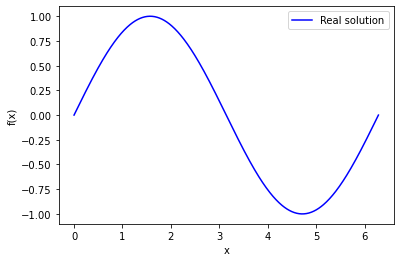

In [9]:
# Visualize the generated data
fig, ax1 = plt.subplots()
ax1.plot(x.detach().numpy(),y.detach().numpy(),color='blue',label='Real solution')
#ax1.plot(x_train.detach().numpy(),yh.detach().numpy(),color='red',label='Pred_Train')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend()
plt.show()

In [10]:
#def get_training_data(x):
# Nu: Number of training point
# Nf: Number of collocation points

# Set Boundary conditions:
BC_1 = x[0,:]
BC_2 = x[-1,:]

# Total Training points BC1+BC2
all_train = torch.vstack([BC_1,BC_2])

#Select Nu points
idx = np.random.choice(all_train.shape[0], Nu, replace=False) 
x_BC = all_train[idx]

# Select Nf points
# Latin Hypercube sampling for collocation points 
x_PDE = BC_1 + (BC_2-BC_1)*lhs(1,Nf)
x_PDE = torch.vstack((x_PDE,x_BC)) 

In [11]:
x_PDE.shape

torch.Size([252, 1])

In [12]:
lhs(1,Nf).shape

(250, 1)

# Train Neural Network

In [13]:
#Store tensors to GPU
torch.manual_seed(123)
x_PDE=x_PDE.float().to(device)
x_BC=x_BC.to(device)

#Create Model
model = FCN(layers)
print(model)
model.to(device)
params = list(model.parameters())
optimizer = torch.optim.Adam(model.parameters(),lr=lr,amsgrad=False)
start_time = time.time()

FCN(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=1, bias=True)
  )
)


In [14]:
for i in range(steps):
    yh = model(x_PDE)
    loss = model.loss(x_PDE,x_BC)# use mean squared error
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i%(steps/10)==0:
      print(loss)

tensor(1.5134, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.4891e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.7118e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0115, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.6343e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.2241e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.0189e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.9381e-05, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.1512e-05, device='cuda:0', grad_fn=<AddBackward0>)


### Plots

In [15]:
# Function
yh=model(x.to(device))
y=f_BC(x)
#Error
print(model.lossBC(x.to(device)))

tensor(1.6149e-05, device='cuda:0', grad_fn=<MseLossBackward0>)


In [16]:
# Derivative
g=x.to(device)
g=g.clone()
g.requires_grad=True #Enable differentiation
f=model(g)
f_x=autograd.grad(f,g,torch.ones([g.shape[0],1]).to(device),retain_graph=True, create_graph=True)[0]

In [17]:
# Detach from GPU
y_plot=y.detach().numpy()
yh_plot=yh.detach().cpu().numpy()
f_x_plot=f_x.detach().cpu().numpy()

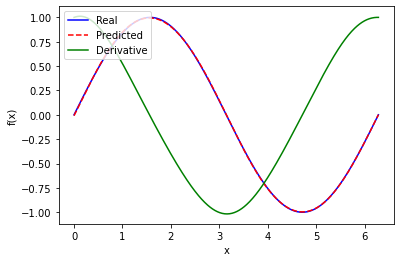

In [18]:
# Plot
fig, ax1 = plt.subplots()
ax1.plot(x,y_plot,color='blue',label='Real')
ax1.plot(x,yh_plot,'--',color='red',label='Predicted')
ax1.plot(x,f_x_plot,color='green',label='Derivative')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')
plt.show()